In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [5]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [6]:
structure.head()

molecule_name  atom_index atom                 x                  y  \
0  dsgdb9nsd_000001           0    C -0.01269531250000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.00214958190918 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.01171875000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.54101562500000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.52392578125000  1.437500000000000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000

In [7]:
# train = train.merge(structure[['x', 'y', 'z', 'molecule_name']], on=['molecule_name'], how='outer')
# test = test.merge(structure[['x', 'y', 'z', 'molecule_name']], on=['molecule_name'], how='outer')

In [8]:
test.shape

(2505542, 5)

In [9]:
y = train['scalar_coupling_constant']

In [15]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structure['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structure['EN'] = atoms_en
structure['rad'] = atoms_rad


{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


In [10]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000

In [16]:
i_atom = structure['atom_index'].values
p = structure[['x', 'y', 'z']].values
p_compare = p
m = structure['molecule_name'].values
m_compare = m
r = structure['rad'].values
r_compare = r

source_row = np.arange(len(structure))
max_atoms = 28

bonds = np.zeros((len(structure)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structure)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structure), mask==0), len(structure), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structure = structure.join(bond_df)

Calculating bonds



Counting and condensing bonds


In [18]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structure, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    #df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [26]:
train.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_index_x', 'atom_0', 'x_0', 'y_0',
       'z_0', 'EN_x', 'rad_x', 'n_bonds_x', 'bond_lengths_mean_x',
       'atom_index_y', 'atom_1', 'x_1', 'y_1', 'z_1', 'EN_y', 'rad_y',
       'n_bonds_y', 'bond_lengths_mean_y'],
      dtype='object')

In [43]:
train_x = pd.read_csv('train_0.csv')

In [44]:
test_x = pd.read_csv('test_0.csv')

In [45]:
train_x['type'] = train['type']
test_x['type'] = test['type']

In [47]:
train = train_x
test = test_x

In [48]:
train.shape

(4658147, 51)

In [49]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [50]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [51]:
train.shape

(4658147, 51)

In [52]:
params = {'num_leaves': 2**4,
          'min_child_samples': 80,
          'objective': 'regression',
          'max_depth': 4,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.1,
          'colsample_bytree': 0.65
         }

In [53]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1']]
#     features = ['atom_index_0', 'atom_index_1']

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 100000
        clf = lgb.train(params, trn_data, num_round, valid_sets=[trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds=100)
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

        predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 2.48132	valid_1's l1: 2.49963
[1000]	training's l1: 2.25087	valid_1's l1: 2.28468
[1500]	training's l1: 2.12201	valid_1's l1: 2.17157
[2000]	training's l1: 2.02968	valid_1's l1: 2.09347
[2500]	training's l1: 1.96087	valid_1's l1: 2.03776
[3000]	training's l1: 1.90582	valid_1's l1: 1.99478
[3500]	training's l1: 1.85678	valid_1's l1: 1.95718
[4000]	training's l1: 1.81447	valid_1's l1: 1.92505
[4500]	training's l1: 1.77797	valid_1's l1: 1.89926
[5000]	training's l1: 1.74477	valid_1's l1: 1.87567
[5500]	training's l1: 1.71509	valid_1's l1: 1.85531
[6000]	training's l1: 1.68671	valid_1's l1: 1.83674
[6500]	training's l1: 1.66083	valid_1's l1: 1.82035
[7000]	training's l1: 1.63621	valid_1's l1: 1.80442
[7500]	training's l1: 1.61375	valid_1's l1: 1.79005
[8000]	training's l1: 1.59295	valid_1's l1: 1.77751
[8500]	training's l1: 1.57304	valid_1's l1: 1.76552
[9000]	training's l1: 1.55414	valid_1's l1: 1.7

[77000]	training's l1: 0.716101	valid_1's l1: 1.45228
[77500]	training's l1: 0.71335	valid_1's l1: 1.45193
[78000]	training's l1: 0.710583	valid_1's l1: 1.45148
[78500]	training's l1: 0.707792	valid_1's l1: 1.45088
[79000]	training's l1: 0.705094	valid_1's l1: 1.45034
[79500]	training's l1: 0.702466	valid_1's l1: 1.44993
[80000]	training's l1: 0.699736	valid_1's l1: 1.4494
[80500]	training's l1: 0.697136	valid_1's l1: 1.44903
[81000]	training's l1: 0.694484	valid_1's l1: 1.44844
[81500]	training's l1: 0.691837	valid_1's l1: 1.44795
[82000]	training's l1: 0.689275	valid_1's l1: 1.44753
[82500]	training's l1: 0.686724	valid_1's l1: 1.44711
[83000]	training's l1: 0.684136	valid_1's l1: 1.44669
[83500]	training's l1: 0.681597	valid_1's l1: 1.44626
[84000]	training's l1: 0.679079	valid_1's l1: 1.44583
[84500]	training's l1: 0.67654	valid_1's l1: 1.44545
Early stopping, best iteration is:
[84744]	training's l1: 0.675294	valid_1's l1: 1.44518
Fold 2
Training until validation scores don't impr

[68500]	training's l1: 0.768235	valid_1's l1: 1.45327
[69000]	training's l1: 0.765131	valid_1's l1: 1.45269
[69500]	training's l1: 0.761977	valid_1's l1: 1.45212
[70000]	training's l1: 0.758895	valid_1's l1: 1.45155
[70500]	training's l1: 0.755902	valid_1's l1: 1.45102
[71000]	training's l1: 0.752828	valid_1's l1: 1.45055
[71500]	training's l1: 0.749824	valid_1's l1: 1.44992
[72000]	training's l1: 0.746783	valid_1's l1: 1.44933
[72500]	training's l1: 0.743843	valid_1's l1: 1.4487
[73000]	training's l1: 0.740933	valid_1's l1: 1.44799
[73500]	training's l1: 0.738017	valid_1's l1: 1.44749
[74000]	training's l1: 0.735125	valid_1's l1: 1.44689
[74500]	training's l1: 0.732237	valid_1's l1: 1.44628
[75000]	training's l1: 0.729335	valid_1's l1: 1.44577
[75500]	training's l1: 0.726493	valid_1's l1: 1.4453
[76000]	training's l1: 0.723703	valid_1's l1: 1.44478
[76500]	training's l1: 0.720916	valid_1's l1: 1.44433
[77000]	training's l1: 0.718144	valid_1's l1: 1.44384
[77500]	training's l1: 0.71544

[44000]	training's l1: 0.950044	valid_1's l1: 1.50415
[44500]	training's l1: 0.94537	valid_1's l1: 1.50302
[45000]	training's l1: 0.940743	valid_1's l1: 1.50185
[45500]	training's l1: 0.936204	valid_1's l1: 1.50068
[46000]	training's l1: 0.931586	valid_1's l1: 1.49945
[46500]	training's l1: 0.927006	valid_1's l1: 1.49832
[47000]	training's l1: 0.922498	valid_1's l1: 1.49707
[47500]	training's l1: 0.918192	valid_1's l1: 1.49602
[48000]	training's l1: 0.913752	valid_1's l1: 1.49481
[48500]	training's l1: 0.909418	valid_1's l1: 1.49354
[49000]	training's l1: 0.905042	valid_1's l1: 1.4923
[49500]	training's l1: 0.900795	valid_1's l1: 1.49123
[50000]	training's l1: 0.896604	valid_1's l1: 1.49017
[50500]	training's l1: 0.892392	valid_1's l1: 1.48883
[51000]	training's l1: 0.888209	valid_1's l1: 1.48783
[51500]	training's l1: 0.88412	valid_1's l1: 1.48693
[52000]	training's l1: 0.879973	valid_1's l1: 1.48581
[52500]	training's l1: 0.875884	valid_1's l1: 1.4849
[53000]	training's l1: 0.871882	

[19500]	training's l1: 1.27569	valid_1's l1: 1.61295
[20000]	training's l1: 1.26606	valid_1's l1: 1.60886
[20500]	training's l1: 1.25662	valid_1's l1: 1.60475
[21000]	training's l1: 1.24752	valid_1's l1: 1.60103
[21500]	training's l1: 1.23846	valid_1's l1: 1.59735
[22000]	training's l1: 1.22956	valid_1's l1: 1.59357
[22500]	training's l1: 1.22097	valid_1's l1: 1.58991
[23000]	training's l1: 1.21249	valid_1's l1: 1.58664
[23500]	training's l1: 1.20432	valid_1's l1: 1.58335
[24000]	training's l1: 1.1961	valid_1's l1: 1.58027
[24500]	training's l1: 1.18807	valid_1's l1: 1.577
[25000]	training's l1: 1.18038	valid_1's l1: 1.57434
[25500]	training's l1: 1.17269	valid_1's l1: 1.57136
[26000]	training's l1: 1.16508	valid_1's l1: 1.56843
[26500]	training's l1: 1.15745	valid_1's l1: 1.56549
[27000]	training's l1: 1.15015	valid_1's l1: 1.56311
[27500]	training's l1: 1.14292	valid_1's l1: 1.56025
[28000]	training's l1: 1.13595	valid_1's l1: 1.55771
[28500]	training's l1: 1.12893	valid_1's l1: 1.55

[3000]	training's l1: 1.89827	valid_1's l1: 1.98615
[3500]	training's l1: 1.84919	valid_1's l1: 1.94807
[4000]	training's l1: 1.80935	valid_1's l1: 1.91889
[4500]	training's l1: 1.7734	valid_1's l1: 1.89284
[5000]	training's l1: 1.73991	valid_1's l1: 1.86931
[5500]	training's l1: 1.71087	valid_1's l1: 1.84956
[6000]	training's l1: 1.68316	valid_1's l1: 1.83105
[6500]	training's l1: 1.65675	valid_1's l1: 1.81369
[7000]	training's l1: 1.63338	valid_1's l1: 1.79924
[7500]	training's l1: 1.61106	valid_1's l1: 1.78554
[8000]	training's l1: 1.58981	valid_1's l1: 1.77274
[8500]	training's l1: 1.57056	valid_1's l1: 1.76164
[9000]	training's l1: 1.55122	valid_1's l1: 1.75027
[9500]	training's l1: 1.5334	valid_1's l1: 1.74031
[10000]	training's l1: 1.51554	valid_1's l1: 1.73025
[10500]	training's l1: 1.4991	valid_1's l1: 1.72131
[11000]	training's l1: 1.48323	valid_1's l1: 1.71253
[11500]	training's l1: 1.4679	valid_1's l1: 1.70462
[12000]	training's l1: 1.45355	valid_1's l1: 1.69746
[12500]	tra

[80000]	training's l1: 0.698637	valid_1's l1: 1.44767
[80500]	training's l1: 0.695973	valid_1's l1: 1.44736
[81000]	training's l1: 0.693324	valid_1's l1: 1.44691
[81500]	training's l1: 0.690687	valid_1's l1: 1.44655
[82000]	training's l1: 0.688118	valid_1's l1: 1.44612
[82500]	training's l1: 0.685585	valid_1's l1: 1.44575
[83000]	training's l1: 0.683017	valid_1's l1: 1.44534
[83500]	training's l1: 0.680423	valid_1's l1: 1.44478
[84000]	training's l1: 0.677862	valid_1's l1: 1.44436
[84500]	training's l1: 0.675319	valid_1's l1: 1.44402
[85000]	training's l1: 0.672828	valid_1's l1: 1.44363
[85500]	training's l1: 0.670364	valid_1's l1: 1.44324
[86000]	training's l1: 0.667934	valid_1's l1: 1.44275
[86500]	training's l1: 0.665496	valid_1's l1: 1.44237
[87000]	training's l1: 0.663105	valid_1's l1: 1.44211
[87500]	training's l1: 0.660642	valid_1's l1: 1.44169
[88000]	training's l1: 0.658234	valid_1's l1: 1.44131
[88500]	training's l1: 0.655817	valid_1's l1: 1.44092
[89000]	training's l1: 0.653

[9000]	training's l1: 0.201971	valid_1's l1: 0.58889
[9500]	training's l1: 0.192167	valid_1's l1: 0.587928
[10000]	training's l1: 0.182762	valid_1's l1: 0.586814
[10500]	training's l1: 0.174292	valid_1's l1: 0.585861
[11000]	training's l1: 0.166482	valid_1's l1: 0.584972
[11500]	training's l1: 0.158931	valid_1's l1: 0.584166
[12000]	training's l1: 0.151853	valid_1's l1: 0.583357
[12500]	training's l1: 0.145074	valid_1's l1: 0.582541
Early stopping, best iteration is:
[12700]	training's l1: 0.1425	valid_1's l1: 0.582015
Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 1.21762	valid_1's l1: 1.22671
[1000]	training's l1: 1.122	valid_1's l1: 1.13628
[1500]	training's l1: 1.06515	valid_1's l1: 1.08518
[2000]	training's l1: 1.02326	valid_1's l1: 1.04801
[2500]	training's l1: 0.993236	valid_1's l1: 1.02228
[3000]	training's l1: 0.967537	valid_1's l1: 1.00061
[3500]	training's l1: 0.945645	valid_1's l1: 0.982551
[4000]	training's l1: 0.92704	valid_1's 

[70500]	training's l1: 0.452747	valid_1's l1: 0.713461
[71000]	training's l1: 0.451359	valid_1's l1: 0.713102
[71500]	training's l1: 0.449965	valid_1's l1: 0.712686
[72000]	training's l1: 0.448591	valid_1's l1: 0.712179
[72500]	training's l1: 0.44722	valid_1's l1: 0.711793
[73000]	training's l1: 0.445876	valid_1's l1: 0.711411
[73500]	training's l1: 0.444551	valid_1's l1: 0.71104
[74000]	training's l1: 0.443201	valid_1's l1: 0.710616
[74500]	training's l1: 0.441871	valid_1's l1: 0.710258
[75000]	training's l1: 0.440514	valid_1's l1: 0.709838
[75500]	training's l1: 0.439205	valid_1's l1: 0.709452
[76000]	training's l1: 0.437912	valid_1's l1: 0.709075
[76500]	training's l1: 0.436603	valid_1's l1: 0.708748
[77000]	training's l1: 0.435312	valid_1's l1: 0.708411
[77500]	training's l1: 0.434009	valid_1's l1: 0.708039
[78000]	training's l1: 0.432734	valid_1's l1: 0.707659
[78500]	training's l1: 0.431443	valid_1's l1: 0.7073
[79000]	training's l1: 0.430186	valid_1's l1: 0.706998
[79500]	traini

[44000]	training's l1: 0.544482	valid_1's l1: 0.741396
[44500]	training's l1: 0.542392	valid_1's l1: 0.740652
[45000]	training's l1: 0.540281	valid_1's l1: 0.739841
[45500]	training's l1: 0.538146	valid_1's l1: 0.739043
[46000]	training's l1: 0.536103	valid_1's l1: 0.738272
[46500]	training's l1: 0.534003	valid_1's l1: 0.737463
[47000]	training's l1: 0.531941	valid_1's l1: 0.736773
[47500]	training's l1: 0.529938	valid_1's l1: 0.736061
[48000]	training's l1: 0.527961	valid_1's l1: 0.735429
[48500]	training's l1: 0.526	valid_1's l1: 0.734781
[49000]	training's l1: 0.524048	valid_1's l1: 0.734096
[49500]	training's l1: 0.522099	valid_1's l1: 0.733449
[50000]	training's l1: 0.520176	valid_1's l1: 0.732821
[50500]	training's l1: 0.518286	valid_1's l1: 0.732166
[51000]	training's l1: 0.516378	valid_1's l1: 0.731487
[51500]	training's l1: 0.514502	valid_1's l1: 0.730862
[52000]	training's l1: 0.512597	valid_1's l1: 0.730209
[52500]	training's l1: 0.510768	valid_1's l1: 0.729553
[53000]	train

[17500]	training's l1: 0.706896	valid_1's l1: 0.815111
[18000]	training's l1: 0.7023	valid_1's l1: 0.812537
[18500]	training's l1: 0.697778	valid_1's l1: 0.81001
[19000]	training's l1: 0.69342	valid_1's l1: 0.807693
[19500]	training's l1: 0.689156	valid_1's l1: 0.805533
[20000]	training's l1: 0.685067	valid_1's l1: 0.80339
[20500]	training's l1: 0.680911	valid_1's l1: 0.801255
[21000]	training's l1: 0.676878	valid_1's l1: 0.79928
[21500]	training's l1: 0.672901	valid_1's l1: 0.797201
[22000]	training's l1: 0.66903	valid_1's l1: 0.79519
[22500]	training's l1: 0.665164	valid_1's l1: 0.79332
[23000]	training's l1: 0.661339	valid_1's l1: 0.791413
[23500]	training's l1: 0.657606	valid_1's l1: 0.789631
[24000]	training's l1: 0.654034	valid_1's l1: 0.78792
[24500]	training's l1: 0.650487	valid_1's l1: 0.786183
[25000]	training's l1: 0.646986	valid_1's l1: 0.784524
[25500]	training's l1: 0.643526	valid_1's l1: 0.782883
[26000]	training's l1: 0.640037	valid_1's l1: 0.78117
[26500]	training's l1

[92500]	training's l1: 0.398812	valid_1's l1: 0.696285
[93000]	training's l1: 0.397733	valid_1's l1: 0.696022
[93500]	training's l1: 0.396688	valid_1's l1: 0.695759
[94000]	training's l1: 0.395628	valid_1's l1: 0.695498
[94500]	training's l1: 0.394567	valid_1's l1: 0.695193
[95000]	training's l1: 0.393483	valid_1's l1: 0.694941
[95500]	training's l1: 0.392412	valid_1's l1: 0.694703
[96000]	training's l1: 0.391335	valid_1's l1: 0.694453
[96500]	training's l1: 0.390305	valid_1's l1: 0.694232
[97000]	training's l1: 0.389275	valid_1's l1: 0.693998
[97500]	training's l1: 0.388246	valid_1's l1: 0.693716
[98000]	training's l1: 0.387208	valid_1's l1: 0.693491
[98500]	training's l1: 0.386177	valid_1's l1: 0.693267
[99000]	training's l1: 0.385135	valid_1's l1: 0.692988
[99500]	training's l1: 0.384087	valid_1's l1: 0.692722
[100000]	training's l1: 0.383091	valid_1's l1: 0.692488
Did not meet early stopping. Best iteration is:
[100000]	training's l1: 0.383091	valid_1's l1: 0.692488
Fold 4
Training

[66000]	training's l1: 0.465325	valid_1's l1: 0.718587
[66500]	training's l1: 0.463826	valid_1's l1: 0.718091
[67000]	training's l1: 0.46232	valid_1's l1: 0.717683
[67500]	training's l1: 0.460851	valid_1's l1: 0.717221
[68000]	training's l1: 0.459377	valid_1's l1: 0.71679
[68500]	training's l1: 0.457937	valid_1's l1: 0.716353
[69000]	training's l1: 0.456536	valid_1's l1: 0.715951
[69500]	training's l1: 0.455115	valid_1's l1: 0.715559
[70000]	training's l1: 0.453659	valid_1's l1: 0.715065
[70500]	training's l1: 0.452285	valid_1's l1: 0.714708
[71000]	training's l1: 0.450886	valid_1's l1: 0.71432
[71500]	training's l1: 0.449538	valid_1's l1: 0.713996
[72000]	training's l1: 0.448131	valid_1's l1: 0.713542
[72500]	training's l1: 0.446745	valid_1's l1: 0.713125
[73000]	training's l1: 0.445363	valid_1's l1: 0.712662
[73500]	training's l1: 0.443986	valid_1's l1: 0.712325
[74000]	training's l1: 0.442675	valid_1's l1: 0.711995
[74500]	training's l1: 0.441322	valid_1's l1: 0.711638
[75000]	train

[39500]	training's l1: 0.563329	valid_1's l1: 0.751321
[40000]	training's l1: 0.560987	valid_1's l1: 0.750394
[40500]	training's l1: 0.558652	valid_1's l1: 0.749504
[41000]	training's l1: 0.55639	valid_1's l1: 0.74861
[41500]	training's l1: 0.554149	valid_1's l1: 0.747726
[42000]	training's l1: 0.551885	valid_1's l1: 0.746839
[42500]	training's l1: 0.549653	valid_1's l1: 0.74595
[43000]	training's l1: 0.547467	valid_1's l1: 0.74517
[43500]	training's l1: 0.545288	valid_1's l1: 0.744314
[44000]	training's l1: 0.543113	valid_1's l1: 0.74348
[44500]	training's l1: 0.541022	valid_1's l1: 0.742711
[45000]	training's l1: 0.538983	valid_1's l1: 0.741952
[45500]	training's l1: 0.536854	valid_1's l1: 0.741082
[46000]	training's l1: 0.534753	valid_1's l1: 0.740249
[46500]	training's l1: 0.532722	valid_1's l1: 0.739531
[47000]	training's l1: 0.530719	valid_1's l1: 0.738717
[47500]	training's l1: 0.528709	valid_1's l1: 0.737992
[48000]	training's l1: 0.526729	valid_1's l1: 0.737313
[48500]	trainin

[13000]	training's l1: 0.280637	valid_1's l1: 0.382261
[13500]	training's l1: 0.276872	valid_1's l1: 0.380864
[14000]	training's l1: 0.273375	valid_1's l1: 0.379635
[14500]	training's l1: 0.269867	valid_1's l1: 0.378399
[15000]	training's l1: 0.266381	valid_1's l1: 0.377077
[15500]	training's l1: 0.263044	valid_1's l1: 0.37594
[16000]	training's l1: 0.259837	valid_1's l1: 0.374741
[16500]	training's l1: 0.256729	valid_1's l1: 0.37373
[17000]	training's l1: 0.253579	valid_1's l1: 0.372587
[17500]	training's l1: 0.250612	valid_1's l1: 0.371539
[18000]	training's l1: 0.247667	valid_1's l1: 0.370652
[18500]	training's l1: 0.244801	valid_1's l1: 0.369676
[19000]	training's l1: 0.242087	valid_1's l1: 0.368814
[19500]	training's l1: 0.239502	valid_1's l1: 0.368052
[20000]	training's l1: 0.236854	valid_1's l1: 0.367203
[20500]	training's l1: 0.234288	valid_1's l1: 0.366396
[21000]	training's l1: 0.231788	valid_1's l1: 0.365696
[21500]	training's l1: 0.229329	valid_1's l1: 0.365004
[22000]	trai

[39500]	training's l1: 0.165598	valid_1's l1: 0.352259
[40000]	training's l1: 0.164313	valid_1's l1: 0.352026
[40500]	training's l1: 0.163023	valid_1's l1: 0.351715
[41000]	training's l1: 0.161778	valid_1's l1: 0.351479
[41500]	training's l1: 0.160541	valid_1's l1: 0.351232
[42000]	training's l1: 0.1593	valid_1's l1: 0.350965
[42500]	training's l1: 0.158104	valid_1's l1: 0.350727
[43000]	training's l1: 0.156897	valid_1's l1: 0.350529
[43500]	training's l1: 0.155688	valid_1's l1: 0.350286
[44000]	training's l1: 0.154497	valid_1's l1: 0.350069
[44500]	training's l1: 0.153305	valid_1's l1: 0.349891
[45000]	training's l1: 0.152163	valid_1's l1: 0.349674
[45500]	training's l1: 0.151024	valid_1's l1: 0.3495
[46000]	training's l1: 0.149895	valid_1's l1: 0.349236
[46500]	training's l1: 0.148827	valid_1's l1: 0.349121
[47000]	training's l1: 0.147744	valid_1's l1: 0.348949
[47500]	training's l1: 0.146674	valid_1's l1: 0.348755
[48000]	training's l1: 0.145598	valid_1's l1: 0.348524
[48500]	traini

[53500]	training's l1: 0.134576	valid_1's l1: 0.347375
[54000]	training's l1: 0.133638	valid_1's l1: 0.347187
[54500]	training's l1: 0.132736	valid_1's l1: 0.347057
[55000]	training's l1: 0.131831	valid_1's l1: 0.346917
[55500]	training's l1: 0.130938	valid_1's l1: 0.346774
[56000]	training's l1: 0.130068	valid_1's l1: 0.346598
[56500]	training's l1: 0.129193	valid_1's l1: 0.346446
[57000]	training's l1: 0.128332	valid_1's l1: 0.346287
[57500]	training's l1: 0.127485	valid_1's l1: 0.346137
[58000]	training's l1: 0.126618	valid_1's l1: 0.346014
[58500]	training's l1: 0.12578	valid_1's l1: 0.34584
[59000]	training's l1: 0.12495	valid_1's l1: 0.345693
[59500]	training's l1: 0.124127	valid_1's l1: 0.345551
[60000]	training's l1: 0.123297	valid_1's l1: 0.345437
[60500]	training's l1: 0.122482	valid_1's l1: 0.345271
[61000]	training's l1: 0.121664	valid_1's l1: 0.345117
[61500]	training's l1: 0.120878	valid_1's l1: 0.344987
[62000]	training's l1: 0.12008	valid_1's l1: 0.344881
[62500]	traini

[63000]	training's l1: 0.118762	valid_1's l1: 0.341649
[63500]	training's l1: 0.117991	valid_1's l1: 0.341532
Early stopping, best iteration is:
[63738]	training's l1: 0.117622	valid_1's l1: 0.341478
Fold 5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 0.570759	valid_1's l1: 0.583497
[1000]	training's l1: 0.507896	valid_1's l1: 0.527825
[1500]	training's l1: 0.472783	valid_1's l1: 0.499024
[2000]	training's l1: 0.449962	valid_1's l1: 0.481808
[2500]	training's l1: 0.43033	valid_1's l1: 0.46756
[3000]	training's l1: 0.414848	valid_1's l1: 0.45673
[3500]	training's l1: 0.401021	valid_1's l1: 0.447534
[4000]	training's l1: 0.389538	valid_1's l1: 0.440244
[4500]	training's l1: 0.37904	valid_1's l1: 0.433835
[5000]	training's l1: 0.369681	valid_1's l1: 0.428528
[5500]	training's l1: 0.361102	valid_1's l1: 0.423514
[6000]	training's l1: 0.353242	valid_1's l1: 0.419371
[6500]	training's l1: 0.345868	valid_1's l1: 0.415562
[7000]	training's l1: 0.33914	val

[18500]	training's l1: 0.141917	valid_1's l1: 0.411981
[19000]	training's l1: 0.138608	valid_1's l1: 0.411299
[19500]	training's l1: 0.135442	valid_1's l1: 0.410631
[20000]	training's l1: 0.132419	valid_1's l1: 0.410071
[20500]	training's l1: 0.129419	valid_1's l1: 0.40963
[21000]	training's l1: 0.126569	valid_1's l1: 0.409097
[21500]	training's l1: 0.123762	valid_1's l1: 0.408511
[22000]	training's l1: 0.121026	valid_1's l1: 0.408111
[22500]	training's l1: 0.118339	valid_1's l1: 0.407604
[23000]	training's l1: 0.115808	valid_1's l1: 0.407359
[23500]	training's l1: 0.113349	valid_1's l1: 0.407021
[24000]	training's l1: 0.110896	valid_1's l1: 0.406574
[24500]	training's l1: 0.108571	valid_1's l1: 0.40621
[25000]	training's l1: 0.106312	valid_1's l1: 0.405791
[25500]	training's l1: 0.104105	valid_1's l1: 0.405509
[26000]	training's l1: 0.101993	valid_1's l1: 0.405254
[26500]	training's l1: 0.0998943	valid_1's l1: 0.404862
[27000]	training's l1: 0.0978943	valid_1's l1: 0.404531
[27500]	tr

[7000]	training's l1: 0.274789	valid_1's l1: 0.453535
[7500]	training's l1: 0.26509	valid_1's l1: 0.450328
[8000]	training's l1: 0.256054	valid_1's l1: 0.447091
[8500]	training's l1: 0.247505	valid_1's l1: 0.444563
[9000]	training's l1: 0.239663	valid_1's l1: 0.442273
[9500]	training's l1: 0.232181	valid_1's l1: 0.440094
[10000]	training's l1: 0.224856	valid_1's l1: 0.437965
[10500]	training's l1: 0.218062	valid_1's l1: 0.435942
[11000]	training's l1: 0.211567	valid_1's l1: 0.434095
[11500]	training's l1: 0.205493	valid_1's l1: 0.43266
[12000]	training's l1: 0.199647	valid_1's l1: 0.431248
[12500]	training's l1: 0.194119	valid_1's l1: 0.429834
[13000]	training's l1: 0.188891	valid_1's l1: 0.428373
[13500]	training's l1: 0.183789	valid_1's l1: 0.427163
[14000]	training's l1: 0.178733	valid_1's l1: 0.426016
[14500]	training's l1: 0.174029	valid_1's l1: 0.425061
[15000]	training's l1: 0.169567	valid_1's l1: 0.424031
[15500]	training's l1: 0.165257	valid_1's l1: 0.423125
[16000]	training's

[21500]	training's l1: 0.759223	valid_1's l1: 0.863355
[22000]	training's l1: 0.75523	valid_1's l1: 0.861067
[22500]	training's l1: 0.751286	valid_1's l1: 0.858701
[23000]	training's l1: 0.747488	valid_1's l1: 0.856527
[23500]	training's l1: 0.743748	valid_1's l1: 0.854408
[24000]	training's l1: 0.740089	valid_1's l1: 0.852385
[24500]	training's l1: 0.736509	valid_1's l1: 0.850344
[25000]	training's l1: 0.732918	valid_1's l1: 0.848405
[25500]	training's l1: 0.729439	valid_1's l1: 0.84646
[26000]	training's l1: 0.72597	valid_1's l1: 0.84454
[26500]	training's l1: 0.722626	valid_1's l1: 0.842741
[27000]	training's l1: 0.71943	valid_1's l1: 0.841032
[27500]	training's l1: 0.716213	valid_1's l1: 0.839277
[28000]	training's l1: 0.712915	valid_1's l1: 0.837484
[28500]	training's l1: 0.7097	valid_1's l1: 0.835764
[29000]	training's l1: 0.706506	valid_1's l1: 0.83399
[29500]	training's l1: 0.703373	valid_1's l1: 0.832338
[30000]	training's l1: 0.700383	valid_1's l1: 0.830741
[30500]	training's

[96500]	training's l1: 0.472319	valid_1's l1: 0.735616
[97000]	training's l1: 0.471234	valid_1's l1: 0.735254
[97500]	training's l1: 0.470157	valid_1's l1: 0.734899
[98000]	training's l1: 0.4691	valid_1's l1: 0.734564
[98500]	training's l1: 0.468063	valid_1's l1: 0.734224
[99000]	training's l1: 0.467008	valid_1's l1: 0.733876
[99500]	training's l1: 0.46598	valid_1's l1: 0.733565
[100000]	training's l1: 0.464939	valid_1's l1: 0.733247
Did not meet early stopping. Best iteration is:
[100000]	training's l1: 0.464939	valid_1's l1: 0.733247
Fold 2
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 1.33771	valid_1's l1: 1.34597
[1000]	training's l1: 1.24058	valid_1's l1: 1.25276
[1500]	training's l1: 1.18064	valid_1's l1: 1.19605
[2000]	training's l1: 1.13706	valid_1's l1: 1.1558
[2500]	training's l1: 1.10217	valid_1's l1: 1.12412
[3000]	training's l1: 1.07363	valid_1's l1: 1.09912
[3500]	training's l1: 1.04995	valid_1's l1: 1.07871
[4000]	training's l1: 1.02

[70500]	training's l1: 0.535525	valid_1's l1: 0.757575
[71000]	training's l1: 0.534143	valid_1's l1: 0.757076
[71500]	training's l1: 0.532698	valid_1's l1: 0.75653
[72000]	training's l1: 0.531261	valid_1's l1: 0.756008
[72500]	training's l1: 0.529899	valid_1's l1: 0.755548
[73000]	training's l1: 0.528539	valid_1's l1: 0.755073
[73500]	training's l1: 0.527161	valid_1's l1: 0.754586
[74000]	training's l1: 0.52578	valid_1's l1: 0.754079
[74500]	training's l1: 0.524436	valid_1's l1: 0.753588
[75000]	training's l1: 0.523105	valid_1's l1: 0.753126
[75500]	training's l1: 0.521783	valid_1's l1: 0.752634
[76000]	training's l1: 0.52045	valid_1's l1: 0.752148
[76500]	training's l1: 0.519125	valid_1's l1: 0.751684
[77000]	training's l1: 0.517803	valid_1's l1: 0.751198
[77500]	training's l1: 0.51649	valid_1's l1: 0.7507
[78000]	training's l1: 0.515184	valid_1's l1: 0.750209
[78500]	training's l1: 0.513869	valid_1's l1: 0.749713
[79000]	training's l1: 0.512567	valid_1's l1: 0.749268
[79500]	training

[44500]	training's l1: 0.626074	valid_1's l1: 0.793154
[45000]	training's l1: 0.623912	valid_1's l1: 0.792139
[45500]	training's l1: 0.621819	valid_1's l1: 0.791142
[46000]	training's l1: 0.619715	valid_1's l1: 0.790162
[46500]	training's l1: 0.617631	valid_1's l1: 0.789289
[47000]	training's l1: 0.615596	valid_1's l1: 0.788385
[47500]	training's l1: 0.613573	valid_1's l1: 0.787488
[48000]	training's l1: 0.611561	valid_1's l1: 0.786589
[48500]	training's l1: 0.609549	valid_1's l1: 0.785702
[49000]	training's l1: 0.607561	valid_1's l1: 0.784831
[49500]	training's l1: 0.605624	valid_1's l1: 0.783995
[50000]	training's l1: 0.603681	valid_1's l1: 0.783219
[50500]	training's l1: 0.601786	valid_1's l1: 0.782407
[51000]	training's l1: 0.599858	valid_1's l1: 0.781574
[51500]	training's l1: 0.597963	valid_1's l1: 0.780791
[52000]	training's l1: 0.596051	valid_1's l1: 0.780015
[52500]	training's l1: 0.594191	valid_1's l1: 0.77922
[53000]	training's l1: 0.592367	valid_1's l1: 0.778402
[53500]	tra

[18500]	training's l1: 0.783466	valid_1's l1: 0.881351
[19000]	training's l1: 0.778925	valid_1's l1: 0.878587
[19500]	training's l1: 0.77451	valid_1's l1: 0.875822
[20000]	training's l1: 0.770107	valid_1's l1: 0.873075
[20500]	training's l1: 0.765933	valid_1's l1: 0.87054
[21000]	training's l1: 0.761734	valid_1's l1: 0.867995
[21500]	training's l1: 0.757691	valid_1's l1: 0.865611
[22000]	training's l1: 0.753609	valid_1's l1: 0.863183
[22500]	training's l1: 0.749661	valid_1's l1: 0.860873
[23000]	training's l1: 0.745802	valid_1's l1: 0.85867
[23500]	training's l1: 0.742024	valid_1's l1: 0.856523
[24000]	training's l1: 0.738433	valid_1's l1: 0.854575
[24500]	training's l1: 0.734811	valid_1's l1: 0.852512
[25000]	training's l1: 0.731215	valid_1's l1: 0.850424
[25500]	training's l1: 0.727721	valid_1's l1: 0.848435
[26000]	training's l1: 0.724236	valid_1's l1: 0.846411
[26500]	training's l1: 0.720897	valid_1's l1: 0.844571
[27000]	training's l1: 0.717608	valid_1's l1: 0.84276
[27500]	traini

[93500]	training's l1: 0.478119	valid_1's l1: 0.73979
[94000]	training's l1: 0.476994	valid_1's l1: 0.739416
[94500]	training's l1: 0.475884	valid_1's l1: 0.739079
[95000]	training's l1: 0.47479	valid_1's l1: 0.738701
[95500]	training's l1: 0.473714	valid_1's l1: 0.738375
[96000]	training's l1: 0.472671	valid_1's l1: 0.738072
[96500]	training's l1: 0.471572	valid_1's l1: 0.737722
[97000]	training's l1: 0.470505	valid_1's l1: 0.737399
[97500]	training's l1: 0.469418	valid_1's l1: 0.737063
[98000]	training's l1: 0.468344	valid_1's l1: 0.736705
[98500]	training's l1: 0.467283	valid_1's l1: 0.736378
[99000]	training's l1: 0.466231	valid_1's l1: 0.736032
[99500]	training's l1: 0.465203	valid_1's l1: 0.735732
[100000]	training's l1: 0.464154	valid_1's l1: 0.735416
Did not meet early stopping. Best iteration is:
[100000]	training's l1: 0.464154	valid_1's l1: 0.735416
Fold 5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 1.3432	valid_1's l1: 1.35429
[1000]	

[67500]	training's l1: 0.54465	valid_1's l1: 0.761769
[68000]	training's l1: 0.543162	valid_1's l1: 0.761143
[68500]	training's l1: 0.541701	valid_1's l1: 0.760629
[69000]	training's l1: 0.54023	valid_1's l1: 0.760065
[69500]	training's l1: 0.538764	valid_1's l1: 0.759494
[70000]	training's l1: 0.537353	valid_1's l1: 0.758954
[70500]	training's l1: 0.53593	valid_1's l1: 0.758428
[71000]	training's l1: 0.534519	valid_1's l1: 0.757959
[71500]	training's l1: 0.533102	valid_1's l1: 0.757413
[72000]	training's l1: 0.531706	valid_1's l1: 0.756911
[72500]	training's l1: 0.530327	valid_1's l1: 0.756422
[73000]	training's l1: 0.528957	valid_1's l1: 0.755909
[73500]	training's l1: 0.52759	valid_1's l1: 0.755378
[74000]	training's l1: 0.526216	valid_1's l1: 0.754845
[74500]	training's l1: 0.524833	valid_1's l1: 0.754339
[75000]	training's l1: 0.523449	valid_1's l1: 0.753828
[75500]	training's l1: 0.522116	valid_1's l1: 0.753322
[76000]	training's l1: 0.520762	valid_1's l1: 0.752809
[76500]	traini

[41000]	training's l1: 0.234344	valid_1's l1: 0.395741
[41500]	training's l1: 0.232932	valid_1's l1: 0.395371
[42000]	training's l1: 0.231515	valid_1's l1: 0.394989
[42500]	training's l1: 0.230129	valid_1's l1: 0.394586
[43000]	training's l1: 0.228739	valid_1's l1: 0.394181
[43500]	training's l1: 0.227376	valid_1's l1: 0.393758
[44000]	training's l1: 0.226051	valid_1's l1: 0.393401
[44500]	training's l1: 0.224741	valid_1's l1: 0.393063
[45000]	training's l1: 0.223439	valid_1's l1: 0.392759
[45500]	training's l1: 0.222152	valid_1's l1: 0.392435
[46000]	training's l1: 0.220854	valid_1's l1: 0.392051
[46500]	training's l1: 0.219585	valid_1's l1: 0.391756
[47000]	training's l1: 0.218321	valid_1's l1: 0.39144
[47500]	training's l1: 0.217077	valid_1's l1: 0.391105
[48000]	training's l1: 0.215875	valid_1's l1: 0.390816
[48500]	training's l1: 0.214644	valid_1's l1: 0.390462
[49000]	training's l1: 0.213433	valid_1's l1: 0.390141
[49500]	training's l1: 0.212241	valid_1's l1: 0.38983
[50000]	trai

[14500]	training's l1: 0.352792	valid_1's l1: 0.44304
[15000]	training's l1: 0.349081	valid_1's l1: 0.441378
[15500]	training's l1: 0.345461	valid_1's l1: 0.439657
[16000]	training's l1: 0.341953	valid_1's l1: 0.438091
[16500]	training's l1: 0.338517	valid_1's l1: 0.436431
[17000]	training's l1: 0.335291	valid_1's l1: 0.434965
[17500]	training's l1: 0.332039	valid_1's l1: 0.433517
[18000]	training's l1: 0.328932	valid_1's l1: 0.432159
[18500]	training's l1: 0.325791	valid_1's l1: 0.430756
[19000]	training's l1: 0.322793	valid_1's l1: 0.429461
[19500]	training's l1: 0.319948	valid_1's l1: 0.428317
[20000]	training's l1: 0.317059	valid_1's l1: 0.427083
[20500]	training's l1: 0.314338	valid_1's l1: 0.42599
[21000]	training's l1: 0.311586	valid_1's l1: 0.424824
[21500]	training's l1: 0.30888	valid_1's l1: 0.423762
[22000]	training's l1: 0.306275	valid_1's l1: 0.422776
[22500]	training's l1: 0.303729	valid_1's l1: 0.421733
[23000]	training's l1: 0.301252	valid_1's l1: 0.420769
[23500]	train

[8000]	training's l1: 0.415438	valid_1's l1: 0.471393
[8500]	training's l1: 0.409162	valid_1's l1: 0.467605
[9000]	training's l1: 0.403298	valid_1's l1: 0.46427
[9500]	training's l1: 0.397728	valid_1's l1: 0.461112
[10000]	training's l1: 0.392382	valid_1's l1: 0.458227
[10500]	training's l1: 0.38727	valid_1's l1: 0.455413
[11000]	training's l1: 0.382308	valid_1's l1: 0.452707
[11500]	training's l1: 0.37764	valid_1's l1: 0.450321
[12000]	training's l1: 0.373159	valid_1's l1: 0.447983
[12500]	training's l1: 0.368695	valid_1's l1: 0.445578
[13000]	training's l1: 0.364442	valid_1's l1: 0.44339
[13500]	training's l1: 0.360386	valid_1's l1: 0.441476
[14000]	training's l1: 0.356389	valid_1's l1: 0.439503
[14500]	training's l1: 0.35252	valid_1's l1: 0.437477
[15000]	training's l1: 0.348968	valid_1's l1: 0.435807
[15500]	training's l1: 0.345367	valid_1's l1: 0.434129
[16000]	training's l1: 0.34206	valid_1's l1: 0.43269
[16500]	training's l1: 0.338694	valid_1's l1: 0.431141
[17000]	training's l1

[83000]	training's l1: 0.152374	valid_1's l1: 0.374485
[83500]	training's l1: 0.151694	valid_1's l1: 0.374367
[84000]	training's l1: 0.151014	valid_1's l1: 0.374214
[84500]	training's l1: 0.150345	valid_1's l1: 0.374078
[85000]	training's l1: 0.14968	valid_1's l1: 0.373939
[85500]	training's l1: 0.149023	valid_1's l1: 0.373808
[86000]	training's l1: 0.148377	valid_1's l1: 0.373718
[86500]	training's l1: 0.14774	valid_1's l1: 0.373608
[87000]	training's l1: 0.147093	valid_1's l1: 0.373495
[87500]	training's l1: 0.14645	valid_1's l1: 0.373373
[88000]	training's l1: 0.145809	valid_1's l1: 0.373255
[88500]	training's l1: 0.145188	valid_1's l1: 0.373136
[89000]	training's l1: 0.144575	valid_1's l1: 0.373015
[89500]	training's l1: 0.143966	valid_1's l1: 0.372906
[90000]	training's l1: 0.143341	valid_1's l1: 0.372805
[90500]	training's l1: 0.142725	valid_1's l1: 0.372701
[91000]	training's l1: 0.142103	valid_1's l1: 0.372599
[91500]	training's l1: 0.141496	valid_1's l1: 0.372464
[92000]	train

[56500]	training's l1: 0.196372	valid_1's l1: 0.387909
[57000]	training's l1: 0.19534	valid_1's l1: 0.387635
[57500]	training's l1: 0.194307	valid_1's l1: 0.38738
[58000]	training's l1: 0.19328	valid_1's l1: 0.387129
[58500]	training's l1: 0.192251	valid_1's l1: 0.386864
[59000]	training's l1: 0.191246	valid_1's l1: 0.386607
[59500]	training's l1: 0.190266	valid_1's l1: 0.386377
[60000]	training's l1: 0.189286	valid_1's l1: 0.38614
[60500]	training's l1: 0.188314	valid_1's l1: 0.385876
[61000]	training's l1: 0.187355	valid_1's l1: 0.385624
[61500]	training's l1: 0.18643	valid_1's l1: 0.3854
[62000]	training's l1: 0.185477	valid_1's l1: 0.385156
[62500]	training's l1: 0.184533	valid_1's l1: 0.384928
[63000]	training's l1: 0.183589	valid_1's l1: 0.384723
[63500]	training's l1: 0.182698	valid_1's l1: 0.38451
[64000]	training's l1: 0.181796	valid_1's l1: 0.384296
[64500]	training's l1: 0.180889	valid_1's l1: 0.384117
[65000]	training's l1: 0.179976	valid_1's l1: 0.383926
[65500]	training's

[30000]	training's l1: 0.270521	valid_1's l1: 0.407033
[30500]	training's l1: 0.268658	valid_1's l1: 0.406425
[31000]	training's l1: 0.266743	valid_1's l1: 0.405798
[31500]	training's l1: 0.264891	valid_1's l1: 0.405262
[32000]	training's l1: 0.263066	valid_1's l1: 0.404603
[32500]	training's l1: 0.261257	valid_1's l1: 0.404035
[33000]	training's l1: 0.259497	valid_1's l1: 0.403498
[33500]	training's l1: 0.257743	valid_1's l1: 0.402941
[34000]	training's l1: 0.256001	valid_1's l1: 0.402395
[34500]	training's l1: 0.254289	valid_1's l1: 0.401841
[35000]	training's l1: 0.252613	valid_1's l1: 0.401315
[35500]	training's l1: 0.250949	valid_1's l1: 0.400751
[36000]	training's l1: 0.249328	valid_1's l1: 0.40028
[36500]	training's l1: 0.247733	valid_1's l1: 0.399817
[37000]	training's l1: 0.246176	valid_1's l1: 0.399381
[37500]	training's l1: 0.244637	valid_1's l1: 0.398928
[38000]	training's l1: 0.243079	valid_1's l1: 0.398476
[38500]	training's l1: 0.241579	valid_1's l1: 0.398056
[39000]	tra

[3500]	training's l1: 0.260643	valid_1's l1: 0.321807
[4000]	training's l1: 0.249826	valid_1's l1: 0.316574
[4500]	training's l1: 0.240601	valid_1's l1: 0.312406
[5000]	training's l1: 0.232165	valid_1's l1: 0.308737
[5500]	training's l1: 0.224327	valid_1's l1: 0.305658
[6000]	training's l1: 0.217189	valid_1's l1: 0.303105
[6500]	training's l1: 0.210358	valid_1's l1: 0.300494
[7000]	training's l1: 0.204105	valid_1's l1: 0.298418
[7500]	training's l1: 0.198203	valid_1's l1: 0.296178
[8000]	training's l1: 0.192539	valid_1's l1: 0.294295
[8500]	training's l1: 0.187181	valid_1's l1: 0.292504
[9000]	training's l1: 0.182274	valid_1's l1: 0.290863
[9500]	training's l1: 0.177542	valid_1's l1: 0.289344
[10000]	training's l1: 0.173071	valid_1's l1: 0.287937
[10500]	training's l1: 0.168911	valid_1's l1: 0.286851
[11000]	training's l1: 0.164891	valid_1's l1: 0.285624
[11500]	training's l1: 0.16102	valid_1's l1: 0.284658
[12000]	training's l1: 0.157268	valid_1's l1: 0.283633
[12500]	training's l1: 0

[25500]	training's l1: 0.0925089	valid_1's l1: 0.268436
[26000]	training's l1: 0.0909295	valid_1's l1: 0.268112
[26500]	training's l1: 0.0894376	valid_1's l1: 0.26788
[27000]	training's l1: 0.0879562	valid_1's l1: 0.267586
[27500]	training's l1: 0.0865303	valid_1's l1: 0.267405
[28000]	training's l1: 0.0850864	valid_1's l1: 0.267156
[28500]	training's l1: 0.0837307	valid_1's l1: 0.266936
[29000]	training's l1: 0.0824124	valid_1's l1: 0.266746
[29500]	training's l1: 0.0810933	valid_1's l1: 0.266499
[30000]	training's l1: 0.0797911	valid_1's l1: 0.266271
[30500]	training's l1: 0.0785117	valid_1's l1: 0.266057
[31000]	training's l1: 0.0772852	valid_1's l1: 0.265847
[31500]	training's l1: 0.0760933	valid_1's l1: 0.265669
[32000]	training's l1: 0.0749235	valid_1's l1: 0.265504
[32500]	training's l1: 0.0737542	valid_1's l1: 0.265327
[33000]	training's l1: 0.0726539	valid_1's l1: 0.265135
[33500]	training's l1: 0.0715514	valid_1's l1: 0.264985
[34000]	training's l1: 0.070479	valid_1's l1: 0.2

[38500]	training's l1: 0.0616233	valid_1's l1: 0.265349
[39000]	training's l1: 0.0607403	valid_1's l1: 0.265245
[39500]	training's l1: 0.0598946	valid_1's l1: 0.265128
[40000]	training's l1: 0.0590411	valid_1's l1: 0.265017
[40500]	training's l1: 0.0582027	valid_1's l1: 0.264919
[41000]	training's l1: 0.0573845	valid_1's l1: 0.264792
[41500]	training's l1: 0.0565937	valid_1's l1: 0.264687
[42000]	training's l1: 0.0557998	valid_1's l1: 0.26458
[42500]	training's l1: 0.0550193	valid_1's l1: 0.264502
[43000]	training's l1: 0.0542502	valid_1's l1: 0.264403
[43500]	training's l1: 0.0535067	valid_1's l1: 0.264305
[44000]	training's l1: 0.0527741	valid_1's l1: 0.264235
[44500]	training's l1: 0.0520542	valid_1's l1: 0.264141
[45000]	training's l1: 0.0513559	valid_1's l1: 0.264056
Early stopping, best iteration is:
[45313]	training's l1: 0.0509168	valid_1's l1: 0.263983
Fold 5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 0.408014	valid_1's l1: 0.425166
[10

In [54]:
predictions

array([  7.9608262 , 174.82171534,   5.3474412 , ...,   6.22025694,
         8.69569773, 121.21684017])

In [55]:
test.shape

(2505542, 51)

In [56]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [57]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [58]:
sub.shape

(2505542, 2)

In [59]:
len(predictions)

2505542

In [60]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.1.3.csv", index=False)

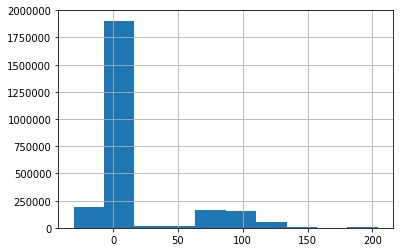

In [61]:
sub['scalar_coupling_constant'].hist()

In [63]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.1.3.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.1.3.csv', index=False)